In [ ]:
import matplotlib.pyplot as plt
import corner
import numpy as np
import taurex.log
taurex.log.disableLogging()
from daneel.parameters import Parameters
import os

#all taurex modules needed
#atmospheric models
from taurex.temperature import Guillot2010, Isothermal
#planet
from taurex.planet import Planet
#star
from taurex.stellar import PhoenixStar, BlackbodyStar
#chemistry
from taurex.cache import OpacityCache,CIACache
from taurex.chemistry import TaurexChemistry, ConstantGas
#models
from taurex.model import TransmissionModel,EmissionModel, DirectImageModel
#physical processes
#absorption
from taurex.contributions import AbsorptionContribution
#CIA (collisional induced absorption)
from taurex.contributions import CIAContribution
#scattering
from taurex.contributions import RayleighContribution

#binning
from taurex.binning import FluxBinner,SimpleBinner

#retrival
from taurex.optimizer.nestle import NestleOptimizer
from taurex.data.spectrum.observed import ObservedSpectrum




class AtmosphereForwardModel:

    def __init__(self, params):
        # Globals parameters
        globals = params.get("Global")
        self.output_file_name = globals['output_file']
        self.xsec_path = globals['xsec_path']
        self.cia_path = globals['cia_path']
        self.phoenix_path = globals.get('phoenix_path', False)
        
        # Model
        model = params.get('Model')
        self.model_type = model['type']
        self.physical_processes = model['physical_processes']
        
        # Atmospheric model
        atmospheric_model = params.get("Atmospheric_model")
        self.atm_model_type = atmospheric_model["type"]
        self.atmospheric_parameters = {key: float(val) for key, val in atmospheric_model["parameters"].items()}
        
        # Planet
        planet = params.get('Planet')
        self.planet_parameters = {key: float(val) for key, val in planet.items()}
        
        # Star
        star = params.get('Star')
        self.star_type = star['type']
        self.star_parameters = {key: float(val) for key, val in star['parameters'].items()}
        
        # Chemistry
        atmospheric_composition = params.get('Chemistry')
        self.main_species = {
            "fill_gases": atmospheric_composition['main_species']['fill_gases'],
            "ratio": float(atmospheric_composition['main_species']['ratio']),
        }
        self.other_molecules = {
            molecule: {
                "gas_type": properties["gas_type"],
                "mix_ratio": float(properties["mix_ratio"]),
            }
            for molecule, properties in atmospheric_composition['other_molecules'].items()
        }
        
        # Pressure
        pressure = params.get('Pressure')
        self.atm_min_pressure = float(pressure['atm_min_pressure'])
        self.atm_max_pressure = float(pressure['atm_max_pressure'])
        self.nlayers = int(pressure['nlayers'])
        
        # Retrieval
        self.path_to_observed_spectrum = params.get('path_to_observed_spectrum')
        self.num_live_points = float(params.get('num_live_points',50))
        self.tol = float(params.get('tol',0.5))
        
    def construct_taurex_model(self):
        OpacityCache().clear_cache()
        OpacityCache().set_opacity_path(self.xsec_path)
        CIACache().set_cia_path(self.cia_path)
        #atmospheric model
        if self.atm_model_type == "isothermal":
            temperature_model = Isothermal(**self.atmospheric_parameters)  # Passa direttamente T
        elif self.atm_model_type == "guillot":
            temperature_model = Guillot2010(**self.atmospheric_parameters)  # Passa tutti i parametri richiesti
        else:
            error_message = f"Model {self.atm_model_type} not available!"
            raise ValueError(error_message)
        
        #planet
        planet = Planet(**self.planet_parameters)
        
        #star
        if self.star_type == 'phoenix' and self.phoenix_path:
            star = PhoenixStar(phoenix_path=self.phoenix_path,**self.star_parameters)
        elif self.star_type == 'blackbody' or self.phoenix_path == False:
            star = BlackbodyStar(**self.star_parameters)
            
        #chemistry
        OpacityCache().clear_cache()
        OpacityCache().set_opacity_path(self.xsec_path)
        CIACache().set_cia_path(self.cia_path)
        
        chemistry = TaurexChemistry(fill_gases=self.main_species["fill_gases"],
                ratio=self.main_species["ratio"])
        for molecule, properties in self.other_molecules.items():
            gas = ConstantGas(molecule, mix_ratio=properties["mix_ratio"])
            chemistry.addGas(gas)
            print(f"Added molecule: {molecule}, mix_ratio: {properties['mix_ratio']}")

        #building atmosphere
        if self.model_type == 'transmission':
            self.model = TransmissionModel(planet=planet,
                                temperature_profile=temperature_model,
                                chemistry=chemistry,
                                star=star,
                                atm_min_pressure=self.atm_min_pressure,
                                atm_max_pressure=self.atm_max_pressure,
                                nlayers=self.nlayers)
        elif self.model_type == 'emission':
            self.model = EmissionModel(planet=planet,
                                temperature_profile=temperature_model,
                                chemistry=chemistry,
                                star=star,
                                atm_min_pressure=self.atm_min_pressure,
                                atm_max_pressure=self.atm_max_pressure,
                                nlayers=self.nlayers)
        elif self.model_type == 'direct_image':
            self.model = DirectImageModel(planet=planet,
                                temperature_profile=temperature_model,
                                chemistry=chemistry,
                                star=star,
                                atm_min_pressure=self.atm_min_pressure,
                                atm_max_pressure=self.atm_max_pressure,
                                nlayers=self.nlayers) 
        
        #physical processes in the atmosphere
        #absorption
        if self.physical_processes['Absorption']:
            self.model.add_contribution(AbsorptionContribution())
            print("Added Absorption Contribution")
            
        #rayleigh scattering
        if self.physical_processes['Absorption']:
            self.model.add_contribution(RayleighContribution())
            print("Added Rayleigh Contribution")

        #CIA (collisional induced absorption)
        if self.physical_processes['CIA'].get('enabled'):
            cia_pairs = self.physical_processes["CIA"].get("pairs", [])
            self.model.add_contribution(CIAContribution(cia_pairs=cia_pairs))
            print(f"Added CIA Contribution with pairs: {cia_pairs}")
            
        #build the model
        print('Building the model')
        self.model.build()
        print('Model built correctly')

        
    def ForwardModel(self):

        #running the model
        #original_wavenumber_grid, rprs, tau, _ = self.result
        #Make a logarithmic grid
        wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
        bn = SimpleBinner(wngrid=wngrid)
        print('Running the model')
        bin_wavenumber, bin_rprs,_,_  = bn.bin_model(self.model.model(wngrid=wngrid))
        print('Complete')
        
        # Save the spectrum data
        wavelength = 10000 / bin_wavenumber  # Convert wavenumber to microns
        rprs_squared = bin_rprs**2
        rprs_error = np.zeros(len(rprs_squared)) + np.std(rprs_squared)
        #rprs_error = np.sqrt(rprs_squared)

        spectrum_data = np.column_stack((wavelength, rprs_squared, rprs_error))
        np.savetxt(self.output_file_name, spectrum_data, header="wavelength(micron) (rp/rs)^2 std((rp/rs)^2)", fmt="%.8e")
        
        # Plotting the transmission spectrum
        plt.figure(figsize=(10, 6))
        plt.errorbar(
            wavelength, rprs_squared, yerr=rprs_error, fmt='o', color='blue', markersize=2, 
            ecolor='lightblue', elinewidth=1, capsize=2, label="Transmission Spectrum"
        )
        plt.xlabel("Wavelength (micron)")
        plt.ylabel("$(R_p/R_s)^2$")
        plt.title("Transmission Spectrum")
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.xscale('log')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def Retrival(self):
        #parameters of the nested sampling algorithm
        opt = NestleOptimizer(num_live_points=self.num_live_points, tol=self.tol)

        try:
            obs = ObservedSpectrum(self.path_to_observed_spectrum)
        except:
            error_message = f"Observed spectrum not found at {self.path_to_observed_spectrum}!"
            raise ValueError(error_message)
        
        # Binned for plotting
        obin = obs.create_binner()

        opt.set_model(self.model)
        opt.set_observed(obs)

        # List of possible parameters
        fitting_params = list(self.model.fittingParameters.keys())
        print("Available fitting parameters:")
        for i, param in enumerate(fitting_params, 1):
            print(f"{i}: {param}")
        
        # Interattività per scegliere i parametri da fittare
        print("\nEnter the indices of the parameters you want to include in the fitting, separated by commas (e.g., 1,3):")
        selected_indices = input("Indices: ")
        selected_params = [fitting_params[int(idx) - 1] for idx in selected_indices.split(",")]

        # Specifica i boundary per ciascun parametro
        boundaries = {}
        for param in selected_params:
            print(f"\nSpecify the boundary for parameter '{param}' as 'lower,upper' (e.g., 0.1,1.0):")
            bounds = input(f"Boundary for {param}: ")
            lower, upper = map(float, bounds.split(","))
            boundaries[param] = (lower, upper)

        # Imposta i parametri da fittare con i boundary
        for param, (lower, upper) in boundaries.items():
            opt.enable_fit(param)
            opt.set_boundary(param,[lower,upper])
            print(f"Parameter '{param}' added with bounds: {lower}, {upper}")

        # retrival
        print("\nRunning the optimizer...")
        solution = opt.fit()
        taurex.log.disableLogging()
        print("Optimization complete!")

        #plot
        for sol_num, map_values, median_values, extra in opt.get_solution():
            stats, fitting_params, raw_traces, raw_weights = extra

            # Update the model with the best-fit (MAP) parameters
            opt.update_model(map_values)

            # Extract observed and best-fit spectrum
            obs_wavelength = obs.wavelengthGrid
            obs_spectrum = obs.spectrum
            obs_error = obs.errorBar
            _, bestfit_spectrum, _, _ = obin.bin_model(self.model.model(obs.wavenumberGrid))

            # Extract parameter information
            param_dict = fitting_params[1]  
            param_names = list(param_dict.keys())
            print("Parameter Names:", param_names)

            # Print MAP and Median estimates for each parameter
            for pname, mv, medv in zip(param_names, map_values, median_values):
                print(f"{pname}: MAP={mv}, Median={medv}")

        # At this point, 'obs_wavelength', 'obs_spectrum', 'obs_error', and 'bestfit_spectrum' 
        # refer to the last solution from the loop above.

        # Plot the best-fit transmission spectrum
        plt.figure()
        plt.errorbar(obs_wavelength, obs_spectrum, obs_error, fmt='o', color='black', label='Observed')
        plt.plot(obs_wavelength, bestfit_spectrum, color='red', label='Best Fit Model')
        plt.xscale('log')
        plt.xlabel('Wavelength (μm)')
        plt.ylabel('(R$_p$/R$_s$)²')
        plt.title('Best Fit Transmission Spectrum')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

        # Compute (R_p/R_s)^2 and its standard deviation
        rprs_sq = bestfit_spectrum**2
        rprs_std = np.std(rprs_sq)
        rprs_error = np.full_like(rprs_sq, rprs_std)

        # Save data to a txt file: wavelength, (Rp/Rs)^2, std((Rp/Rs)^2)
        data = np.column_stack([obs_wavelength, rprs_sq, rprs_error])
        np.savetxt(self.output_file_name, data, 
                header='wavelength(micron) (Rp/Rs)^2 std((Rp/Rs)^2)', 
                fmt='%.8e')

        # Retrieve samples and weights from the solution (usually the first solution)
        samples = opt.get_samples(0)
        weights = opt.get_weights(0)

        # Create the corner plot (works for any number of parameters)
        fig = corner.corner(
            samples,
            weights=weights,
            labels=param_names,
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True,
            title_fmt=".2f",
            color="blue"
        )

        plt.show()

    

In [2]:
params=Parameters('taskE.yaml').params
prova=AtmosphereForwardModel(params)
prova.construct_taurex_model()
#prova.ForwardModel()

Added molecule: H2O, mix_ratio: 0.00012
Added Absorption Contribution
Added Rayleigh Contribution
Added CIA Contribution with pairs: ['H2-H2', 'H2-He']
Building the model
Model built correctly


Running the model
Complete
Available fitting parameters:
1: planet_mass
2: planet_radius
3: planet_distance
4: planet_sma
5: atm_min_pressure
6: atm_max_pressure
7: T
8: H2O
9: He_H2

Enter the indices of the parameters you want to include in the fitting, separated by commas (e.g., 1,3):

Specify the boundary for parameter 'planet_radius' as 'lower,upper' (e.g., 0.1,1.0):

Specify the boundary for parameter 'T' as 'lower,upper' (e.g., 0.1,1.0):

Specify the boundary for parameter 'H2O' as 'lower,upper' (e.g., 0.1,1.0):
Parameter 'planet_radius' added with bounds: 0.8, 1.2
Parameter 'T' added with bounds: 1000.0, 2000.0
Parameter 'H2O' added with bounds: 0.0001, 0.00015

Running the optimizer...
it=   593 logz=1873.2155252253niter: 594
ncall: 1141
nsamples: 644
logz: 1873.604 +/-  0.444
h:  9.852
Optimization complete!
Parameter Names: ['planet_radius', 'T', 'log_H2O']
planet_radius: MAP=0.977927452421648, Median=0.9779006837759705
T: MAP=1462.4972134316074, Median=1445.549227178416
log

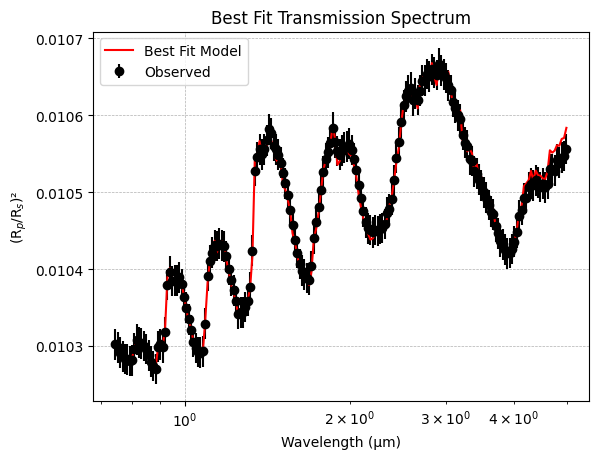

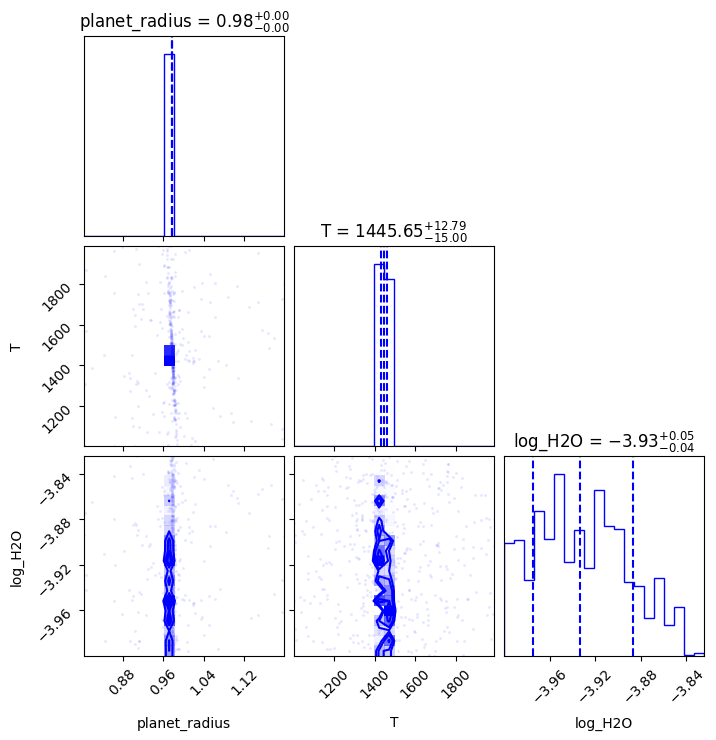

In [3]:

prova.Retrival()